In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

C:\Users\johbr\AppData\Local\Temp\ipykernel_1884\138741423.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# import data
df = pd.read_csv("../resources/ames_housing_data.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# display numerical features
df_num = df.select_dtypes(include=["float64", "int64"])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


## Data Preprocessing

In [4]:
# fill missing values with the mean for each numerical feature
df = df.fillna(df_num.mean())

In [5]:
# drop 'Id'
df = df.drop("Id", axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Dropping Neighborhood

In [6]:
df = df[['OverallQual', 'OverallCond', 'GrLivArea', 'TotRmsAbvGrd', 'YearBuilt', 'SalePrice']]
df.head()

,OverallQual,OverallCond,GrLivArea,TotRmsAbvGrd,YearBuilt,SalePrice
0,7,5,1710,8,2003,208500
1,6,8,1262,6,1976,181500
2,7,5,1786,6,2001,223500
3,7,5,1717,7,1915,140000
4,8,5,2198,9,2000,250000


In [7]:
# drop outliers (rooms with more than 4000 square feet)
df = df[df.GrLivArea <= 4000]

In [8]:
# get_dummies for categorical data
dummies = pd.get_dummies(df)
dummies.head()

,OverallQual,OverallCond,GrLivArea,TotRmsAbvGrd,YearBuilt,SalePrice
0,7,5,1710,8,2003,208500
1,6,8,1262,6,1976,181500
2,7,5,1786,6,2001,223500
3,7,5,1717,7,1915,140000
4,8,5,2198,9,2000,250000


In [9]:
# split data into target and features
y = dummies.SalePrice.values
X = dummies.drop(columns="SalePrice").values

# split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# scale the data
scaler = StandardScaler()

# fit the scaler only to the training data
# to prevent data leakage (e.g., mean and standard deviation not modified by X_test and X_val)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# df just to plot the data immediately below
scaled_df = pd.DataFrame(X_train, columns=dummies.drop(columns="SalePrice").columns)

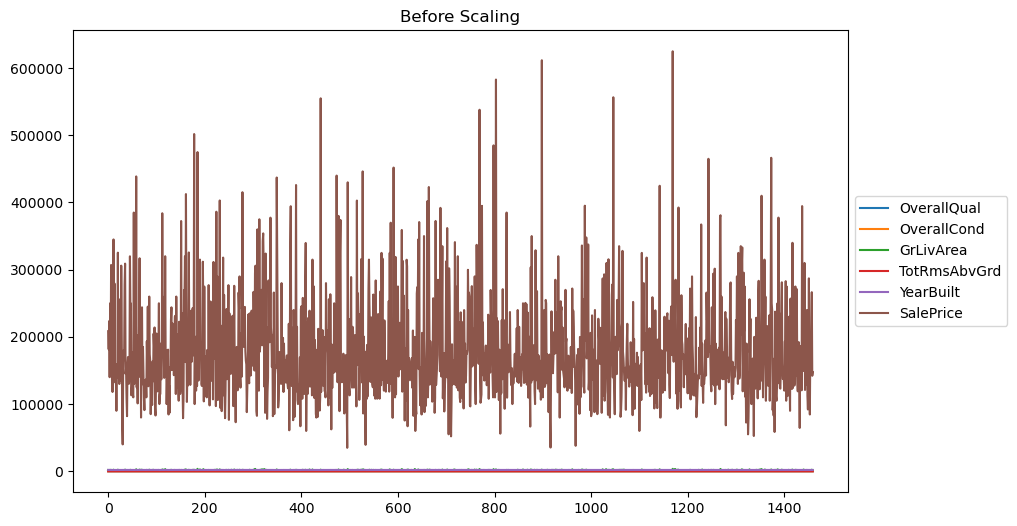

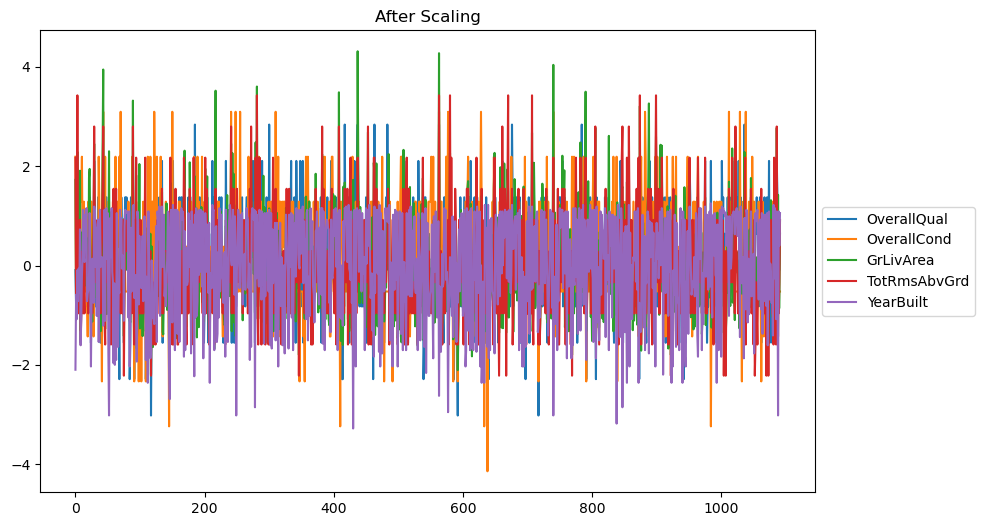

In [10]:
# plot data before scaling
dummies.plot(title='Before Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# after scaling
scaled_df.plot(title='After Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

The outlier is in neighborhood

## Compile, Train, Evaluate the Model

In [11]:
# build keras-tuner function
def build_model(hp):
    nn_test = tf.keras.models.Sequential()

    # adds a range of 1 to 5 dense layers, allowable number of neurons (adjust based on features), activation functions
    for i in range(hp.Int("num_layers", min_value=1, max_value=4, step=1)):
        nn_test.add(
            tf.keras.layers.Dense(
                units=hp.Int(f"layer{i}", min_value=20, max_value=300, step=2),
                input_dim=len(X_train[0]),
                activation=hp.Choice(f"activation{i}", values=["relu", "tanh", "LeakyReLU"])
            )
        )

    # add final layer
    nn_test.add(tf.keras.layers.Dense(units=1, activation="linear"))

    # compile the model
    nn_test.compile(
        loss="mean_absolute_error",
        optimizer="adam",
        metrics=["mae"],
    )

    return nn_test

In [12]:

# define tuner / call the build_model function
tuner = RandomSearch(build_model, objective="mae", max_trials=10, overwrite=True)

# run the damn thing
tuner.search(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
)

Trial 10 Complete [00h 00m 10s]
mae: 182009.609375

Best mae So Far: 21578.435546875
Total elapsed time: 00h 02m 01s


In [13]:
# summary of results
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="mae", direction="min")

Trial 07 summary
Hyperparameters:
num_layers: 3
layer0: 254
activation0: LeakyReLU
layer1: 254
activation1: relu
layer2: 176
activation2: LeakyReLU
Score: 21578.435546875

Trial 00 summary
Hyperparameters:
num_layers: 3
layer0: 28
activation0: tanh
layer1: 20
activation1: relu
layer2: 20
activation2: relu
Score: 36637.98828125

Trial 05 summary
Hyperparameters:
num_layers: 1
layer0: 134
activation0: relu
layer1: 150
activation1: LeakyReLU
layer2: 70
activation2: tanh
Score: 178087.359375

Trial 01 summary
Hyperparameters:
num_layers: 2
layer0: 176
activation0: LeakyReLU
layer1: 258
activation1: tanh
layer2: 204
activation2: LeakyReLU
Score: 181377.125

Trial 04 summary
Hyperparameters:
num_layers: 3
layer0: 72
activation0: relu
layer1: 174
activation1: LeakyReLU
layer2: 202
activation2: tanh
Score: 181588.15625

Trial 08 summary
Hyperparameters:
num_layers: 1
layer0: 20
activati

In [14]:
# get the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hps.values)
print("---")

# build that model
nn = tuner.hypermodel.build(best_hps)

# add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# train the model
fit_model = nn.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Best Hyperparameters:
{'num_layers': 3, 'layer0': 254, 'activation0': 'LeakyReLU', 'layer1': 254, 'activation1': 'relu', 'layer2': 176, 'activation2': 'LeakyReLU'}
---
Epoch 1/100
35/35 [==============================] - 1s 9ms/step - loss: 182302.4688 - mae: 182302.4688 - val_loss: 174336.7969 - val_mae: 174336.7969
Epoch 2/100
35/35 [==============================] - 0s 3ms/step - loss: 181852.9062 - mae: 181852.9062 - val_loss: 173046.4531 - val_mae: 173046.4531
Epoch 3/100
35/35 [==============================] - 0s 2ms/step - loss: 178365.5781 - mae: 178365.5781 - val_loss: 165471.4219 - val_mae: 165471.4219
Epoch 4/100
35/35 [==============================] - 0s 2ms/step - loss: 163463.2188 - mae: 163463.2188 - val_loss: 139082.0781 - val_mae: 139082.0781
Epoch 5/100
35/35 [==============================] - 0s 2ms/step - loss: 123529.8750 - mae: 123529.8750 - val_loss: 85152.6016 - val_mae: 85152.6016
Epoch 6/100
35/35 [==============================] - 0s 2ms/step - loss: 65189.

In [15]:
# summarize final model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 254)               1524      
                                                                 
 dense_3 (Dense)             (None, 254)               64770     
                                                                 
 dense_4 (Dense)             (None, 176)               44880     
                                                                 
 dense_5 (Dense)             (None, 1)                 177       
                                                                 
Total params: 111351 (434.96 KB)
Trainable params: 111351 (434.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# print weights, just because
all_weights = nn.get_weights()
for i, layer_weights in enumerate(all_weights):
    print(f"Layer {i} Weights:")
    print(layer_weights)

Layer 0 Weights:
[[ 0.1664257  -0.01699619  0.1125798  ... -0.255937    0.5959115
   0.55347496]
 [ 0.08223503  0.23444255  0.06113143 ...  0.16229053  0.31626305
  -0.10790398]
 [-0.0786899  -0.1416221   0.11749466 ... -0.17533149  0.3511848
   0.41212764]
 [ 0.09279346 -0.06470133  0.10826567 ... -0.07610258  0.14684364
  -0.20198476]
 [-0.00965249 -0.15087016  0.22070138 ... -0.02620313  0.06519287
   0.23477498]]
Layer 1 Weights:
[0.48432535 0.48402607 0.7734264  0.7729786  0.3112548  0.45623738
 0.72286683 0.43634433 0.4704928  0.302108   0.20357579 0.66069
 0.7039078  0.18296213 0.7214262  0.7431204  0.46387497 0.6032165
 0.79904115 0.5452149  0.3094232  0.59532714 0.3122649  0.44849136
 0.74406207 0.47599953 0.6990974  0.7980638  0.43866476 0.71619046
 0.8138707  0.49927986 0.4727802  0.6741883  0.49495    0.36219886
 0.5127122  0.14928861 0.43613136 0.16698359 0.4911864  0.25052634
 0.7926343  0.50308824 0.4451268  0.12421151 0.5349578  0.2641062
 0.44305673 0.48342007 0.382616

In [17]:
# revert scaled data for testing predictions
y_test_pred=nn.predict(X_test)

6/6 [==============================] - 0s 1ms/step


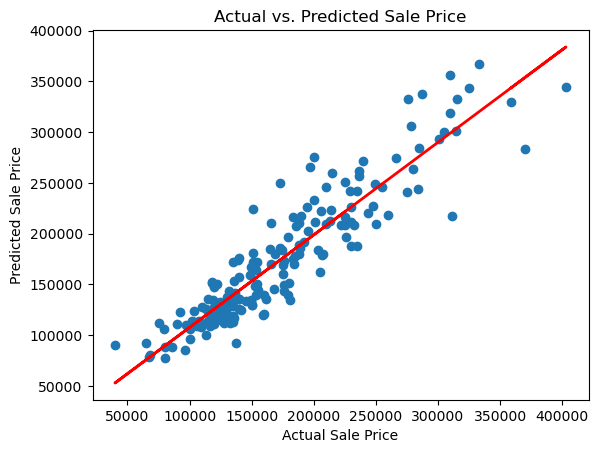

In [18]:
# Scatter plot for actual vs. predicted Sale Price
plt.scatter(y_test, y_test_pred.flatten())
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Price")

# Add a line of best fit
fit = np.polyfit(y_test.flatten(), y_test_pred.flatten(), 1)
line = np.poly1d(fit)
plt.plot(y_test.flatten(), line(y_test.flatten()), color="red", linewidth=2)

plt.show()

In [19]:
# print the r_squared
print(f"R-squared: {r2_score(y_test, y_test_pred)}")

# and other metrics
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Mean Percentage Error: {np.mean((y_test - y_test_pred) / y_test) * 100}")

R-squared: 0.8416842031811572
Mean Squared Error: 687271364.4172515
Mean Absolute Error: 19677.49703811813
Mean Percentage Error: -16.27313615331298


In [20]:
# predict a baseline
# essentially, set every value to the mean and create a fake list of predictions
# compare to above model's predictions
baseline_prediction = y_train.mean()

# create array of baseline predictions with the length of y_test
baseline_predictions = [baseline_prediction] * len(y_test)

print(f"Baseline R-squared: {r2_score(y_test, baseline_predictions)}")
print(
    f"Baseline Mean Squared Error: {mean_squared_error(y_test, baseline_predictions)}"
)
print(
    f"Baseline Mean Absolute Error: {mean_absolute_error(y_test, baseline_predictions)}"
)
print(
    f"Mean Percentage Error: {np.mean((y_test - baseline_predictions) / y_test) * 100}"
)

Baseline R-squared: -0.020610114208674313
Baseline Mean Squared Error: 4430613494.197803
Baseline Mean Absolute Error: 54345.8021978022
Mean Percentage Error: -21.726878869297774


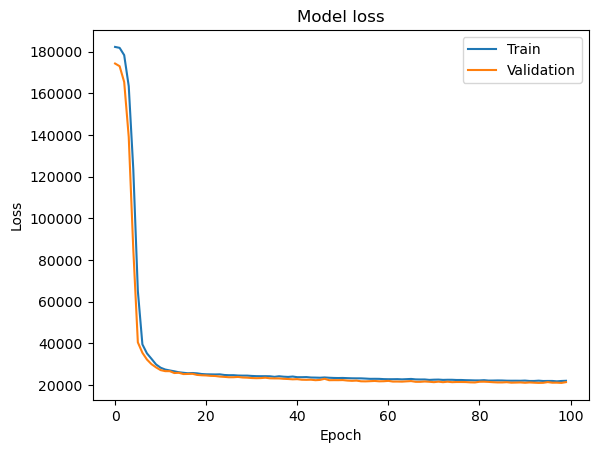

In [21]:
# plot training & validation loss values
# hopefully these both drop quickly and stabilize
# if not...
# validation loss up and training down? overfitting
# training and validation high? underfitting
plt.plot(fit_model.history["loss"])
plt.plot(fit_model.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

6/6 [==============================] - 0s 1ms/step


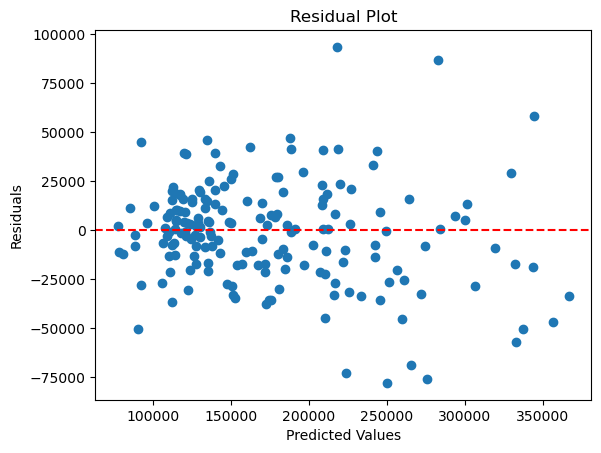

In [22]:
# residual plot
# difference between actual and predicted values
# you want there to be a rnadom distribution around the red line, zero
residuals = y_test - nn.predict(X_test).flatten()
plt.scatter(nn.predict(X_test).flatten(), residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

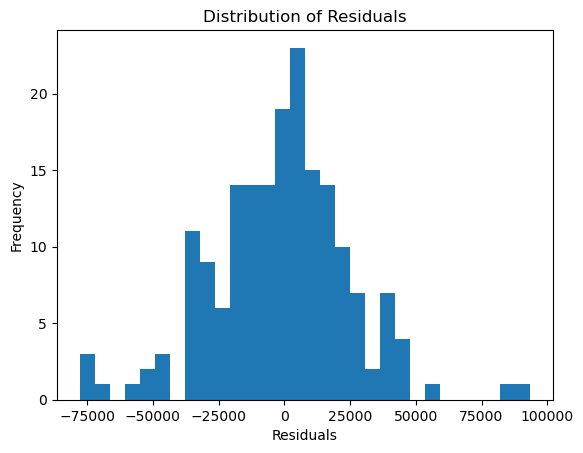

In [23]:
# distribution of residuals
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

In [24]:
# plot the learning curve?